# Hamiltonian manipulation routines implementation

## Pauli string commutation 

```
Reggio et al, Fast Partitioning of Pauli Strings into Commuting Families for Optimal Expectation Value Measurements of Dense Operators, 2023-06-07
```

In [1]:
from typing import *
from collections import OrderedDict
from itertools import combinations, combinations_with_replacement as re_combi, product
from functools import reduce
from sys import float_info
FLOAT_EPS = 1E4 * float_info.min
from pathlib import Path

import numpy as np
from scipy import linalg
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams.update({"font.serif": "Times New Roman"})


In [2]:
from pauli_op import PauliDecompose

In [3]:
PauliDecompose("XYYZ")

(2, 'IZZZ', 'XXXI')

In [4]:
# utils
def krons(*oper_list): # Operator Kronecker delta
    if len(oper_list) == 1:
        oper_list = oper_list[0]
    return reduce(np.kron, oper_list)
def frobenius_inner(A, B): # Frobenius inner product.
    n, n2 = A.shape
    return np.trace((A.conj().T)@B)/(n)

def get_coef(x_str, z_str): 
    # i coefficient in construction of general pauli-element from XZ elements.
    n = len(x_str)
    x_str = x_str.replace("X", "1")
    x_str = x_str.replace("I", "0")
    z_str = z_str.replace("Z", "1")
    z_str = z_str.replace("I", "0")
    
    x_int = int(x_str, 2)
    z_int = int(z_str, 2)
    
    y_pos = format(x_int&z_int, f"0{n}b")
    z_pos = format((x_int|z_int) - x_int, f"0{n}b")
    x_pos = format((x_int|z_int) - z_int, f"0{n}b")

    g_str = []
    for x,y,z in zip(x_pos, y_pos, z_pos):
        if x==y and y==z:
            g_str.append("I")
        elif x== "1":
            g_str.append("X")
        elif y == "1":
            g_str.append("Y")
        else:
            g_str.append("Z")
    return 1j**y_pos.count("1"), "".join(g_str)
def integer_order_map(int_list):
    sorted_unique = np.unique(np.array(int_list))
    return {num: idx for idx, num in enumerate(sorted_unique)}

In [5]:
I = np.eye(2)
pauli_X = np.array([[0, 1], [1, 0]], dtype=complex)
pauli_Y = complex(0, 1)*np.array([[0, -1], [1, 0]], dtype=complex)
pauli_Z = np.array([[1, 0], [0, -1]], dtype=complex)
p_basis = {"I":I, "X":pauli_X, "Y":pauli_Y, "Z":pauli_Z}

In [6]:
# Sample
#t_h = Hamiltonian()
#commute_map = t_h.get_commute_map() # compatible graph
#latin_matrix = t_h.get_latin_matrix() # get latin matrix

## Routines

1. Decompose the given hermite matrix as Pauli-polynomial. Done
   1. Generate n qubit pauli-matrices. Done
   2. Frobnius inner product. Done
   3. Kronecker product, tensor product on matrix form. Done
2. Compute Latin matrix. Done
3. Generate compatible graph of Pauli-terms or local terms, adjacent matrix. in progress
4. Save and reload the profile - in progress

In [7]:
from __future__ import annotations

In [73]:
def commute_reggio(pa:Tuple[int, int], pb:Tuple[int, int]):
    nx_a, nz_a = pa
    nx_b, nz_b = pb
    
    a = bin(nx_a & nz_b).count("1")%2
    b = bin(nx_b & nz_a).count("1")%2
    return a==b
    
def commute_reggio_df(s):
    a = bin(s[0] & s[3]).count("1")%2
    b = bin(s[1] & s[2]).count("1")%2
    return a == b

In [187]:
float_tol = 1E-8
class Hamiltonian:
    def __init__(self, 
                 H:np.matrix, 
                 tols=(1E4*float_tol , float_tol), 
                 pauli_basis:Union[None, dict]=None,
                 commute_map = False):
        assert len(H.shape) ==2, f"H must be 2dim matrix. current: {H.shape}."
        n1, n2 = H.shape
        assert n1 == n2, f"Hamiltonian must be square matrix. Current:{(n1, n2)}."
        assert np.allclose(H, H.H, *tols), f"Hamiltonian must be a hermite matrix. Relative, absolute tolerance, {tols}."
        assert bin(n1)[2:].count("1") == 1, f"Dimension must be a 2^n. Current:{n1}."
        
        self.Hamiltonian = H
        
        if pauli_basis is None:
            pauli_basis = self.H_to_p_poly(H, tols[1])
        # None or Dataframe
        self.local_decomposition = self.get_decomposition(pauli_basis)  

        # Commute term
        self.commute_map = self.get_commuting_map() if commute_map else None
        self.commute_map_exist = True if commute_map else False
        self.qubit_num = len(bin(H.shape[0])[3:]) # Consider a 1 bit position of 2^n integer.
    #--------------------------------------------------------------
    def get_commuting_map(self):
        df = self.local_decomposition
        edge_df = pd.DataFrame(combinations(df["Pstring"].values ,2), columns=['source', 'target'])
        
        edge_df = edge_df.merge(df[["Pstring", "Z", "X"]], how="left", left_on="source", right_on='Pstring').drop("Pstring", axis=1)
        edge_df.rename(columns={"Z": "Zs", "X": "Xs"}, inplace=True)
        edge_df = edge_df.merge(df[["Pstring", "Z", "X"]], how="left", left_on="target", right_on='Pstring').drop("Pstring", axis=1)
        edge_df.rename(columns={"Z": "Zt", "X": "Xt"}, inplace=True)
        
        edge_df["commute"] = edge_df[["Zs", "Xs", "Zt", "Xt"]].apply(commute_reggio_df, axis=1)
        return edge_df
    def save_as(self, filepath:Union[Path, str]):
        raise NotImplementedError
        if isinstance(filepath, str):
            filepath = Path(filepath)
        pass
    #--------------------------------------------------------------
    @property
    def pauli_decomposition(self):
        return self.local_decomposition.loc[["Pstring", "Coef"]]
    @property
    def xz_family(self):
        return self.local_decomposition.loc[["Z", "X", "Coef"]]
    @property
    def latin_matrix(self):
        return self.local_decomposition.pivot(index="X", columns="Z", values="Coef") 
    #--------------------------------------------------------------
    @classmethod
    def from_latin_matrix(cls:Hamiltonian, 
                      l_matrix:np.matrix, 
                      coefficient:Union[np.matrix, None]=None)->Hamiltonian:
        pass
    @classmethod
    def from_pauli_polynomial(cls:Hamiltonian, 
                               p_poly:Union[dict, np.ndarray], 
                               p_coef:Union[None, np.ndarray]=None)-> Hamiltonian:
        pass
    @classmethod
    def from_data(cls:Hamiltonian, file_path)->Hamiltonian:
        pass
    #------------------------------
    # Basic utils for hamiltonian analysis
    @staticmethod
    def get_decomposition(pauli_basis):
        p_dict = {}
        for p in pauli_basis.keys():
            nx, nz = Hamiltonian.pstr_to_xz_fam_code(p)
            num = 1 if nx>0 else 0
            num += num if nz>0 else 0

            p_dict[p] = (num, nz, nx, pauli_basis[p])
        df = pd.DataFrame.from_dict(
                                    p_dict, 
                                    orient="index",
                                    columns = ["type", "Z", "X", "Coef"])
        df.reset_index(inplace=True, names="Pstring")
        return df
    @staticmethod
    def pstr_to_matrix(pstr):
        result = []
        for p in pstr:
            result.append(p_basis[p])
        return krons(result)
    @staticmethod
    def pstr_to_xz_fam_code(pstr:str)->Tuple[int, int]:
        num = 1
        x_num = 0 # Consider a bit represenation
        z_num = 0

        p_map = {"I":(0,0), "X":(1, 0), "Y":(1,1), "Z":(0,1)}
        for p in reversed(pstr):
            nx, nz = p_map[p]
            x_num += nx*num
            z_num += nz*num
            num += num
        return x_num, z_num
    @staticmethod
    def xz_fam_code_to_pstr(ns:Tuple[int, int], l:int):
        assert l>0, "l must be positive integer and greater than 0."
        nx, nz = ns
        max_int_1 = 2**l
        assert (nx < max_int_1 and nz < max_int_1), "The given integers and the qubit dim are not matched."
        if nx==0:
            st = format(nz, f"0{l}b")
            st = st.replace("0", "I")
            st = st.replace("1", "Z")
            return st
        if nz==0:
            st = format(nx, f"0{l}b")
            st = st.replace("0", "I")
            st = st.replace("1", "X")
            return st
        
        st_x = format(nx, f"0{l}b")
        st_z = format(nz, f"0{l}b")

        result = []
        for x, z in zip(st_x, st_z):
            if x == z:
                if x =="1":
                    result.append("Y")
                else: 
                    result.append("I")
            elif x > z:
                result.append("X")
            else:
                result.append("Z")
        return "".join(result)
    @staticmethod
    def p_poly_to_H(p_poly:dict):
        """Convert pauli-polynomial of dictionary form to total Hamiltonian matrix.
        The given polynomial must be a dictionary whose keys are pauli-terms and the values are coefficient.

        Args:
            pstrs (dict): _description_
        """
        n = len(list(p_poly.keys())[0])
        dim = int(2**n)
        shape = (dim, dim)
        result = np.asmatrix(np.zeros(shape, dtype=complex))
        for pstr in p_poly:
            coef = p_poly[pstr]
            result += coef*Hamiltonian.pstr_to_matrix(pstr)
        return result
    @staticmethod
    def H_to_p_poly(H, tol=float_tol, include_zeros=False):
        n = len(bin(H.shape[0])[3:])
        p_mat, p_str = Hamiltonian.generate_pauli_terms(n)
        poly = {}
        for p_m, p_str in zip(p_mat, p_str):
            coef = frobenius_inner(p_m, H)
            coef = 0 if np.absolute(coef) < tol else coef
            if include_zeros:
                poly[p_str] = coef
            elif coef != 0:
                poly[p_str] = coef
        return poly
    @staticmethod
    def p_poly_to_latin(p_poly:dict, full=False)->Tuple[np.ndarray, list, list]:
        p_terms = list(p_poly.keys())
        x_fam = []
        z_fam = []
        for p in p_terms:
            nx, nz = Hamiltonian.pstr_to_xz_fam_code(p)
            x_fam.append(nx)
            z_fam.append(nz)
            
        x_fam_unique = np.unique(x_fam)
        z_fam_unique = np.unique(z_fam)
        x_l = x_fam_unique.size
        z_l = z_fam_unique.size
        
        x_l_map = integer_order_map(x_fam)
        z_l_map = integer_order_map(z_fam)
        
        latin_matrix = np.zeros(shape=(x_l, z_l), dtype=complex)
        for p, x_i, z_j in zip(p_poly.values(), x_fam, z_fam):
            xi, zi = x_l_map[x_i], z_l_map[z_j]

            latin_matrix[xi, zi] = p 
        return latin_matrix, x_fam_unique, z_fam_unique
    @staticmethod
    def generate_pauli_terms(
        qubit_num:int, 
        only:Literal["both", "string", "matrix"]="both")-> Union[Tuple[Iterable, Iterable], Iterable]:
        """Generate full set of pauli-terms in matrix and strings of `n` number of qubit system.

        Args:
            qubit_num (int): _description_
            only (Literal[&quot;both&quot;, &quot;string&quot;, &quot;matrix&quot;], optional): _description_. Defaults to "both".

        Returns:
            _type_: _description_
        """
        n = int(qubit_num)
        assert n >0, "The given argument must be a positive natural number."
        
        p_xs =  Hamiltonian.get_pauli_family_matrix(n, fam="X")
        p_zs =  Hamiltonian.get_pauli_family_matrix(n, fam="Z")
        p_xs_str = Hamiltonian.get_pauli_family_string(n, fam="X")
        p_zs_str = Hamiltonian.get_pauli_family_string(n, fam="Z")

        result = []
        if only=="both" or only=="matrix":
            p_g = []
            p_g_str =[]
            for x_i, x_str in zip(p_xs, p_xs_str):
                for z_j, z_str in zip(p_zs, p_zs_str):
                    g = x_i@z_j

                    g_coef, g_str = get_coef(x_str, z_str)

                    p_g.append(g_coef*g)
                    p_g_str.append(g_str)
            result.append(p_g) 
            if only =="both":
                result.append(p_g_str)
        elif only=="string":
            p_g_str = []
            for x_str in p_xs_str:
                for z_str in p_zs_str:
                    p_g_str.append(g_str)
            result.append(p_g_str)
        return result
    @staticmethod
    def get_pauli_family_string(n, fam="Z"):
        return list(map(lambda x: "".join(x), product(f"I{fam}", repeat=int(n))))
    @staticmethod
    def get_pauli_family_matrix(n:int, fam="Z")->Iterable[np.matrix]:
        """Get pauli_family of `n` qubits of `fam` family. 

        Args:
            n (int): Number of qubits. The output matrices are :math:`2^n`.
            fam (str, optional): Type of Pauli-family of X, Y, or Z. Defaults to "Z".

        Returns:
            Iterable[np.matrix]: list of Pauli-matrices
        """
        G = pauli_Z if fam=="Z" else (pauli_X if fam=="X" else pauli_Y)

        return list(map(krons, product([I, G], repeat=int(n))))
        

Class implementation test

In [139]:
# Pauli-string to matrix
Hamiltonian.pstr_to_matrix("XX")

array([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [140]:
# Polynomial to total Hamiltonian
poly_test = {
    "YX": 4,
    "II": 3,
    "XZ": 2,
    "ZI" : 0.5
}
# (ZI, XX), (II, II), (XI, IZ)
n = len(list(poly_test.keys())[0])
hamiltonian =Hamiltonian.p_poly_to_H(poly_test)
hamiltonian

matrix([[ 3.5+0.j,  0. +0.j,  2. +0.j,  0. -4.j],
        [ 0. +0.j,  3.5+0.j,  0. -4.j, -2. +0.j],
        [ 2. +0.j,  0. +4.j,  2.5+0.j,  0. +0.j],
        [ 0. +4.j, -2. +0.j,  0. +0.j,  2.5+0.j]])

In [141]:
#Decompose the given hamiltonian into pauli-polynomail with given tolerance
Hamiltonian.H_to_p_poly(hamiltonian, include_zeros=False)

{'II': (3+0j), 'ZI': (0.5+0j), 'XZ': (2+0j), 'YX': (4+0j)}

In [124]:
p_poly_full = Hamiltonian.H_to_p_poly(hamiltonian, include_zeros=True)
print("Full polynomial:\n", p_poly_full)
p_poly_min = Hamiltonian.H_to_p_poly(hamiltonian, include_zeros=False)
print("Essential polynomial:\n", p_poly_min)

Full polynomial:
 {'II': (3+0j), 'IZ': 0, 'ZI': (0.5+0j), 'ZZ': 0, 'IX': 0, 'IY': 0, 'ZX': 0, 'ZY': 0, 'XI': 0, 'XZ': (2+0j), 'YI': 0, 'YZ': 0, 'XX': 0, 'XY': 0, 'YX': (4+0j), 'YY': 0}
Essential polynomial:
 {'II': (3+0j), 'ZI': (0.5+0j), 'XZ': (2+0j), 'YX': (4+0j)}


In [142]:
# Decompose the given Pauli-string into two X, Z family members
nx, nz = Hamiltonian.pstr_to_xz_fam_code("IXYZ")
print(nx, nz)

6 3


In [143]:
# Convert the two X, Z family number to n length pauli-string
Hamiltonian.xz_fam_code_to_pstr((6,3), 6)

'IIIXYZ'

In [127]:
p_poly_min

{'II': (3+0j), 'ZI': (0.5+0j), 'XZ': (2+0j), 'YX': (4+0j)}

In [146]:
# Calculate latin matrix from pauli-polynomial
latin_matrix, x_fam, z_fam = Hamiltonian.p_poly_to_latin(p_poly_min)
print(latin_matrix)
print("X:", x_fam)
print("Z:", z_fam)

[[3. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 2. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 4. +0.j]]
X: [0 2 3]
Z: [0 1 2]


C:\Users\qwqwh\AppData\Local\Temp\ipykernel_2928\4076954183.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  texts_y = ax.set_yticklabels(
C:\Users\qwqwh\AppData\Local\Temp\ipykernel_2928\4076954183.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  texts_x = ax.set_xticklabels(


Text(0.5, 1.0, 'Latin matrix of given pauli-polynomial')

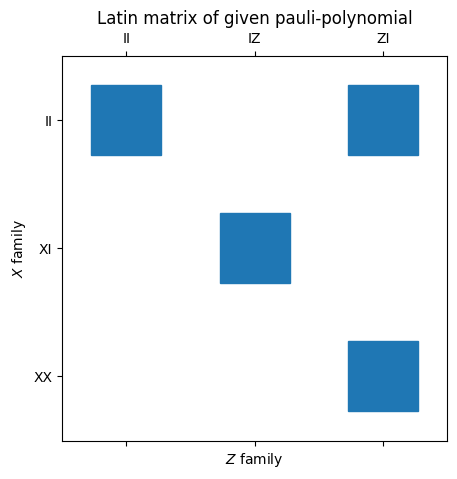

In [147]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.spy(latin_matrix, markersize=50)
ax.set_ylabel("$X$ family")
ax.set_xlabel("$Z$ family")
texts_y = ax.set_yticklabels(
    [""] + [Hamiltonian.xz_fam_code_to_pstr((x,0), l=2) for x in x_fam])
texts_x = ax.set_xticklabels(
    [''] + [Hamiltonian.xz_fam_code_to_pstr((0,z), l=2) for z in z_fam])
ax.set_title("Latin matrix of given pauli-polynomial")

---

In [ ]:
from random import random

In [150]:
# Test with real Hamiltonian terms
pstrs = pd.read_csv("H3+-2.1_node.csv")["Pstring"]

In [151]:
pauli_sample = {}
for p in pstrs:
    pauli_sample[p] = random()

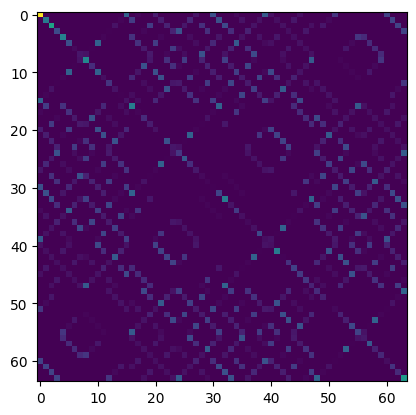

In [154]:
H = Hamiltonian.p_poly_to_H(pauli_sample)
plt.imshow(np.abs(H))

In [188]:
hamiltonian = Hamiltonian(H, pauli_basis=pauli_sample, commute_map=True)

In [189]:
# Automatically, generates Pauli-decomposition
hamiltonian.local_decomposition

,Pstring,type,Z,X,Coef
0,IIIIII,0,0,0,0.684553
1,IIIIIZ,0,1,0,0.445336
2,IIIIZI,0,2,0,0.082172
3,IIIIZZ,0,3,0,0.599295
4,IIIZII,0,4,0,0.345786
...,...,...,...,...,...
61,YZYXZX,2,58,45,0.330589
62,YZZYXX,2,60,39,0.725679
63,YZYZII,2,60,40,0.082786
64,YZZZYZ,2,63,34,0.942844


In [190]:
x_fam = hamiltonian.local_decomposition["X"]
x_fam_unique = x_fam.drop_duplicates()
z_fam = hamiltonian.local_decomposition["Z"].drop_duplicates()
z_fam_unique = z_fam.drop_duplicates()

In [191]:
x_l = x_fam_unique.size
z_l = z_fam_unique.size

In [192]:
x_l_map = integer_order_map(x_fam)
z_l_map = integer_order_map(z_fam)
        
latin_matrix = np.zeros(shape=(x_l, z_l), dtype=complex)

In [193]:
# Commuting map relationship
hamiltonian.commute_map

,source,target,Zs,Xs,Zt,Xt,commute
0,IIIIII,IIIIIZ,0,0,1,0,True
1,IIIIII,IIIIZI,0,0,2,0,True
2,IIIIII,IIIIZZ,0,0,3,0,True
3,IIIIII,IIIZII,0,0,4,0,True
4,IIIIII,IIIZIZ,0,0,5,0,True
...,...,...,...,...,...,...,...
2140,YZZYXX,YZZZYZ,60,39,63,34,False
2141,YZZYXX,YZYYZY,60,39,63,45,False
2142,YZYZII,YZZZYZ,60,40,63,34,False
2143,YZYZII,YZYYZY,60,40,63,45,False


In [194]:
# Graph representation of Commuting map
import networkx as nx

In [195]:
G = nx.from_pandas_edgelist(hamiltonian.commute_map, source='source', target='target', edge_attr
=['commute'])
commute_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d["commute"]]

In [196]:
node_position = nx.kamada_kawai_layout(G)

Text(0.5, 1.0, 'Compatible Graph of H3+ Hamiltonian')

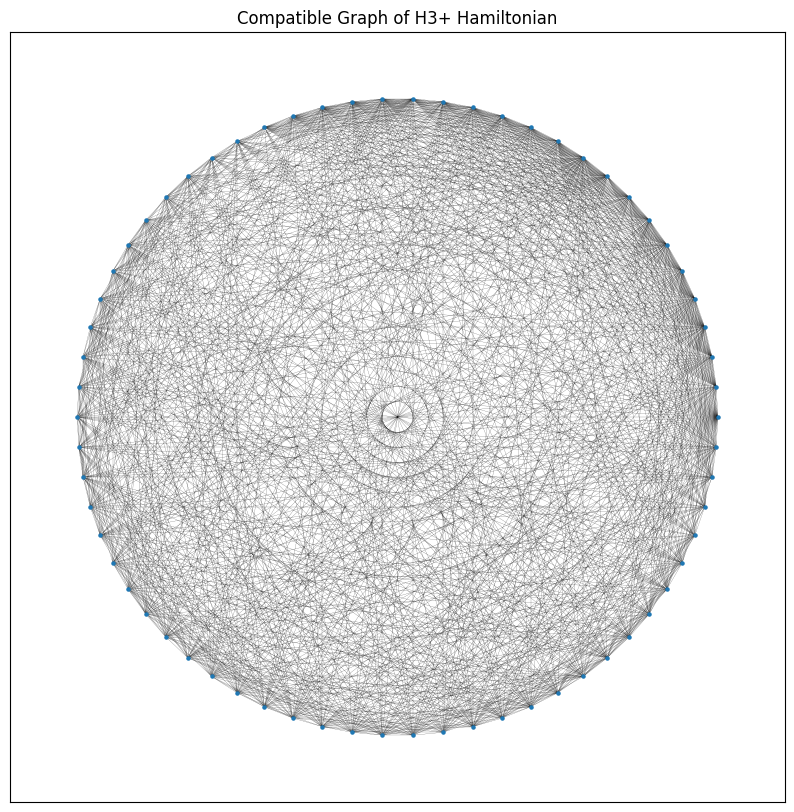

In [197]:
fig, ax= plt.subplots(1,1, figsize=(10, 10))
edges = nx.draw_networkx_edges(
    G, node_position, edgelist= commute_edges , width=0.11, alpha=1,
    ax=ax)
nodes = nx.draw_networkx_nodes(
    G, pos=node_position,
    node_size = 5,
    linewidths = 1,
    #edgecolors="black",
    ax=ax
)
ax.set_title("Compatible Graph of H3+ Hamiltonian")

In [198]:
hamiltonian.latin_matrix

Z,0,1,2,3,4,5,6,8,9,10,...,32,33,34,36,40,48,57,58,60,63
X,,,,,,,,,,,,,,,,,,,,,
0,0.684553,0.445336,0.082172,0.599295,0.345786,0.998986,0.008379,0.511292,0.005925,0.700118,...,0.620724,0.566959,0.443438,0.406887,0.200612,0.714579,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,0.693054,NaN,NaN,0.652235,NaN,0.973698,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,0.804116,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,0.981339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.148111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,0.928606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,0.964076,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050413,NaN,0.942844
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.971229,NaN,0.725679,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.627196,NaN,0.082786,NaN


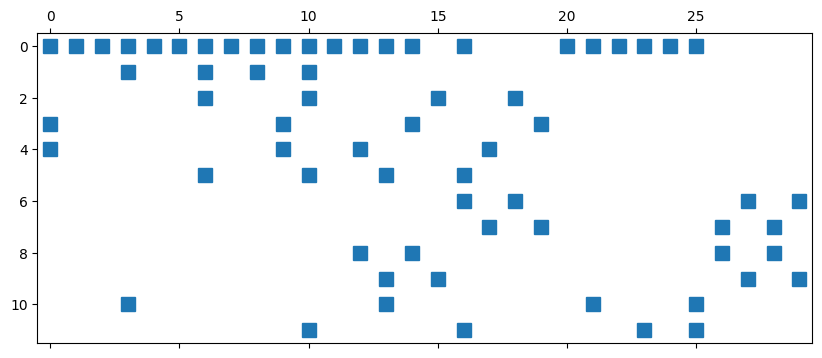

In [200]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.spy(hamiltonian.latin_matrix, markersize=10)